# Homework 6
This homework builds on the effective visualization workshop with the Star Trek data. Below is what we completed in class. Output is suppressed for readability, but you can remove the supression on your code if you'd like.

In [1]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>% 
    group_by(character, episode_number) %>% 
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>% 
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

## Question 1
In class, we left off on the plot below, which shows the distribution of dialog count by mean dialog length, where each point represents an episode. Interpret these results. How can we tell the character's role in the story by their plot?

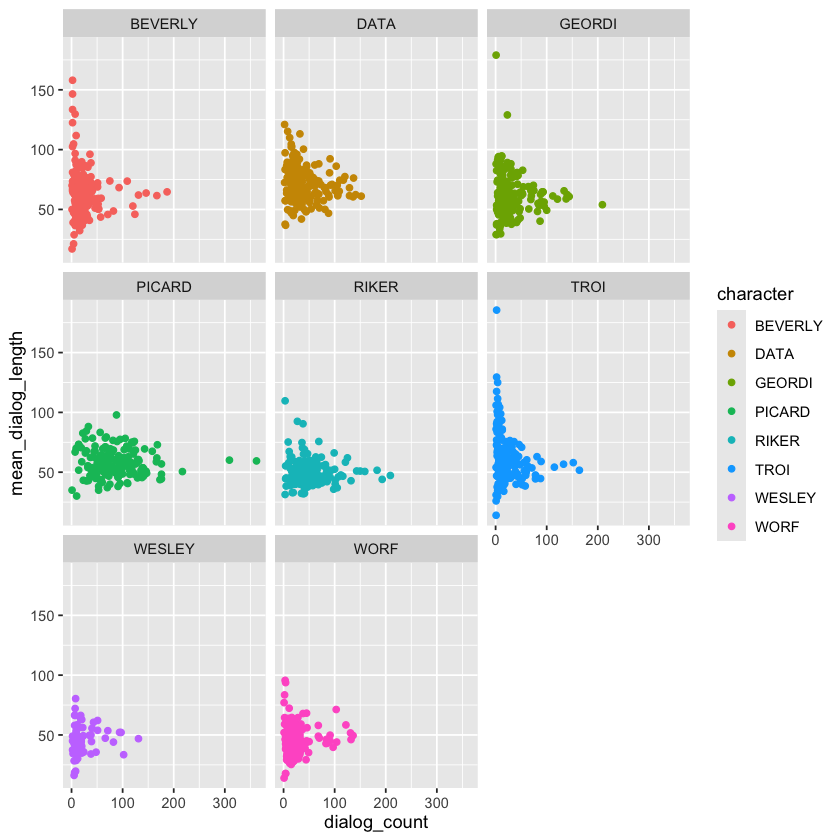

In [2]:
ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + 
    geom_point(aes(color=character)) + 
    facet_wrap(~character)

We can see that based on the distribution, how some characters have more lines, but dont speak on average as long. For instance, Beverly appears to not have many instances where she speaks more than 200 times, but when she does speak, she has some of the longer dialogs. We can tell the character's role in the story by how their plot is distributed. Picard for instance seems to be an important character because his dialog count is higher than the rest of the characters, while Wesley appears to be not as important because his plot is shorter vertically and horizontally, meaning he does not have many lines of dialoge and his average length of dialoge is also small. I think we could say that the lead characters are Picard, Data, and Riker because they consistently have the most dialogue. The characters that are less important have the lowest dialogue count and they could serve specific roles but are not the main focus. The others such as geordi, troi, and beverly have a spread out y axis which could indicate that they are moderately important characters but aren't the main focus. Sometimes they have longer dialogs, which could be a monologue in a specific episode.

## Question 2
#### a) Compare Beverly's mean dialog per episode vs. mean dialog count per episode from season 1 (episodes 102-126) to season 3 (episodes 149-174) in a table.  
*Hints*:  
-   First, use `filter()` to get - 1) the dialog from only Beverly's character and 2) the episodes within the ranges given.
-   Then, add a season variable using `mutate()` with `case_when()`.
-   To create the means per episode, after your `mutate()` step, you'll need to `group_by()` season and episode number, then you can do your `summarize()` step to get the means by episode. At the end of the `summary()` statement (inside the parenthesis), add `.groups="drop"`. 
-   Then, to get the mean of means, you'll do the same as above, but only grouping by season. 

In [25]:
head(dialog_len_per_ep)
df_bev <- dialog_len_per_ep%>%
    filter(character == "BEVERLY" & ((episode_number >= 149 & episode_number <= 174) | (episode_number >= 102 & episode_number <= 126) )) %>%
    mutate(season = case_when(
        (episode_number >= 149 & episode_number <= 174) ~ "3",
        (episode_number >= 102 & episode_number <= 126) ~ "1",
    ))


df_bev_perep <- df_bev%>%
    group_by(season, episode_number)%>%
    summarize(mean_dialog  = mean(mean_dialog_length), .groups = "drop")

df_bev_per_season <- df_bev %>%
    group_by(season)%>%
    summarize(mean_dialog = mean(mean_dialog_length), .groups = "drop")

head(df_bev_perep)
head(df_bev_per_season)

character,episode_number,mean_dialog_length,dialog_count
<chr>,<dbl>,<dbl>,<int>
TROI,129,185.5000,2
GEORDI,249,179.0000,1
BEVERLY,242,158.0000,2
BEVERLY,159,146.5000,2
BEVERLY,261,133.5000,2
BEVERLY,116,129.7143,7


season,episode_number,mean_dialog
<chr>,<dbl>,<dbl>
1,102,56.74194
1,103,58.82222
1,104,55.64706
1,105,69.20000
1,106,57.54545
1,107,36.60000


season,mean_dialog
<chr>,<dbl>
1,56.48460
3,67.04817


#### b) In class, we talked about this character saying the actress has stated that after she was fired and rehired, the writers began giving her storylines that made her feel like a male character. How is this reflected in our table?

We can see that the average mean_dialog for season three is higher compared to season 1. This could indicate that male characters generally have more lines of dialog, which in this case would make sense why Beverly has more dialog in the season which she was rehired


## Question 3
Let's compare the vocabulary richness (unique words / total words) of each character. 
#### a) Tokenize dialog into words, remove punctuation, convert to lowercase. Then filter out the stop words in the list below (from https://gist.github.com/sebleier/554280).
*Hint*: Here's a template for that this step should look like:
```
tokens <- YOUR_DATASET %>%
  # Split each dialog into words
  mutate(word_list = str_split(DIALOG_COLUMN, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% STOPWORDS)
```

In [26]:
stop_words <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)

In [35]:
head(dialogs)
tokens <- dialogs %>%
    mutate(word_list = str_split(dialog, "\\s+")) %>%
    unnest(word_list)%>%
    mutate(
        word = str_remove_all(word_list, "[[:punct:]]"),
        word = str_to_lower(word)
    )%>%
    filter(word != "", !word %in% stop_words)

head(tokens)

episode_number,character,dialog
<dbl>,<chr>,<chr>
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy."
102,PICARD,"My orders are to examine Farpoint, a starbase built there by the inhabitants of that world. Meanwhile ..."
102,PICARD,"... I am becoming better acquainted with my new command, this Galaxy Class U.S.S. Enterprise."
102,PICARD,I am still somewhat in awe of its size and complexity.
102,PICARD,"... my crew we are short in several key positions, most notably ..."
102,PICARD,"... a first officer, but I am informed that a highly experienced man, one Commander William Riker, will be waiting to join our ship when we reach our Cygnus IV destination."


episode_number,character,dialog,word_list,word
<dbl>,<chr>,<chr>,<chr>,<chr>
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",Captain's,captains
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.","log,",log
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",stardate,stardate
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",42353.7.,423537
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",destination,destination
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",planet,planet


#### b) Count unique words per character. Print a summary table with the following columns: character, total words, unique words, and vocabulary richness.  
*Hint*: Group by character, then use `summarize()` to get what you want. You'll use `n_distinct()` to get the unique word counts. Arrange in descending value of vocabulary richness.

In [41]:
token_unique <- tokens %>%
    group_by(character)%>%
    summarize(
      word_tot = n(),
      unique_char = n_distinct(word),
      vocab_rich = unique_char / word_tot
    )%>%
    arrange(desc(vocab_rich))

head(token_unique)

character,word_tot,unique_char,vocab_rich
<chr>,<int>,<int>,<dbl>
AD LIBBED VOICES,7,7,1
ADMIRAL SIMONS,4,4,1
ALANS,14,14,1
ALEXANDRA,3,3,1
ALIEN,17,17,1
ALIEN NURSE,14,14,1


#### c) Plot total words versus vocab richness. 
-   Use the character names as the "points".
    -   *Hint*: Use `geom_text()` to add the character names as the points.
-   Do not include a legend.
    -   *Hint*: Use `theme()` to remove the legend.
-   Add a title and axis titles.
    -   *Hint*: Use `labs()` to add titles.

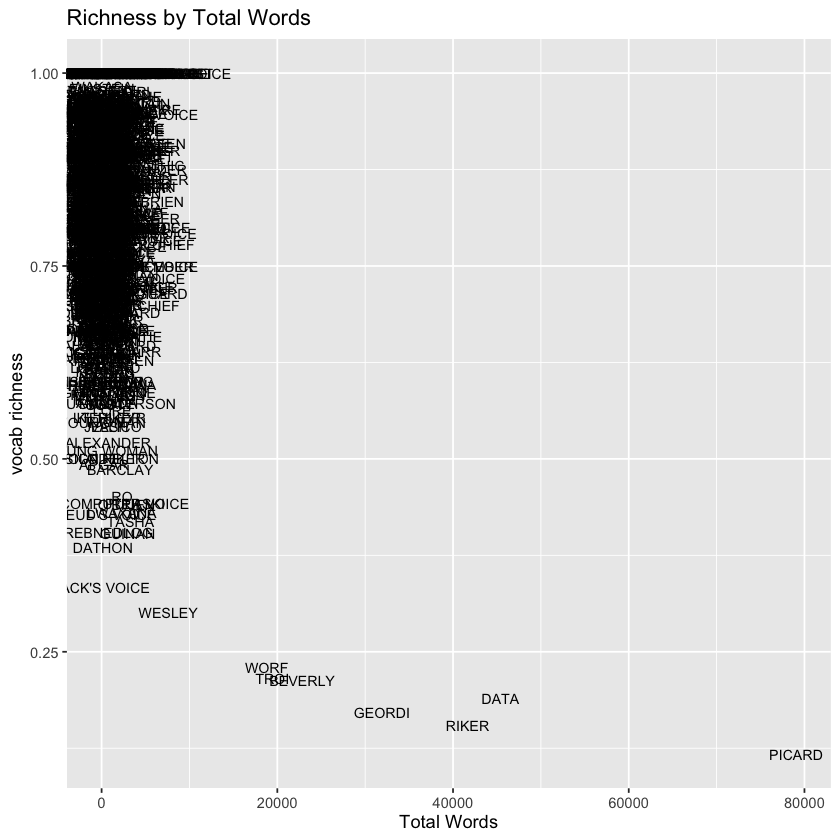

In [45]:
plt <- token_unique %>%
    ggplot(aes(x = word_tot, y = vocab_rich, label = character))+
    geom_text(size = 3)+
    theme(legend.position = "none") +
    labs(
        title = "Richness by Total Words",
        x = "Total Words",
        y = "vocab richness"
    )
    
plt

#### d) Interpret these results. 

We see in this case the characters with less total words often times have greater vocab richness, the more total words, the less richness.

## Question 4
#### a) Find what episode Wesley left the show as a main character and state it explicitly. Meaning, find the first significant gap where he is not found in more than two episodes in a row. 
*Hint*: It's after season 3 (ended at episode 174), so you can filter out seasons 1-3 and print Wesley's dialog count per episode. Then, scan the table for the gap. 

In [70]:
df_wes <- dialog_len_per_ep%>%
    filter(episode_number > 174 & character == "WESLEY")%>%
    select(character, episode_number)%>%
    arrange((episode_number))%>%
    mutate(ep_diff = lead(episode_number) - episode_number,
            following_ep = lead(episode_number),
            gap = case_when(
                ep_diff >2 ~TRUE,
                ep_diff <=2 ~ FALSE
            )
    )%>%
    filter(gap == TRUE)


head(df_wes)




character,episode_number,ep_diff,following_ep,gap
<chr>,<dbl>,<dbl>,<dbl>,<lgl>
WESLEY,183,23,206,TRUE
WESLEY,206,13,219,TRUE
WESLEY,219,44,263,TRUE
WESLEY,263,9,272,TRUE


The episode he left the show as a main character seems to be at 183, he did not appear in 184

#### b) After Wesley leaves the main cast, in which episodes does he make cameo appearances?

In [67]:
df_cameo <- dialog_len_per_ep%>%
    filter(episode_number >=183 & character == "WESLEY")%>%
    select(character, episode_number)%>%
    arrange(episode_number)

df_cameo

character,episode_number
<chr>,<dbl>
WESLEY,183
WESLEY,206
WESLEY,219
WESLEY,263
WESLEY,272


The episodes after are 206,219,263,272

#### c) Dig back into the data. Print:
-   Wesley's last piece of dialog before he left the main cast.
-   Wesley's last piece of dialog ever.  
  
*Hint*: To do this, you'll need to filter the `dialogs_fixed` data set to Welsey's lines and the episode number, and use `slice_tail(n = 1)` to get the last observation.

In [76]:
df_wes_last_dialog <- dialogs_fixed%>%
    filter(character == "WESLEY" & episode_number == 183)%>%
    slice_tail(n = 1)

print(df_wes_last_dialog$dialog)

df_wes_last_dialog_ever <- dialogs_fixed%>%
    filter(character == "WESLEY" & episode_number == 272)%>%
    slice_tail(n = 1)
print(df_wes_last_dialog_ever$dialog)

[1] "I can walk."
[1] "Good-bye, Mom."


## Question 5
Create a heatmap with `dialog_len_per_ep` showing mean dialog length per episode for each character. Sort the characters on the y-axis by their overall mean dialog length, with the lowest on top using a factor. Add a title and an axis title. 
*Hints*:
For the factor:
1. Compute overall mean (mean of mean) dialog length per character (`group_by()` then `summarize()`), and arrange the overall mean in ascending order. Add `pull(character)` to the end of this step so that you can use character as a factor in the next step. Store all of this in a new tibble.
2. Convert character to factor with this order. On `dialog_len_per_ep`, you'll use a mutate statement to add the factor `(mutate(character = factor(character, levels = DATAFROMHINT1))`.
3. Create heatmap using `geom_tile()`.
4. If you want nicer colors, you can add `scale_fill_viridis_c()` (or another color scale) to your ggplot statement. **Not required**, but fun to mess around with!

character,episode_number,mean_dialog_length,dialog_count
<fct>,<dbl>,<dbl>,<int>
TROI,129,185.5000,2
GEORDI,249,179.0000,1
BEVERLY,242,158.0000,2
BEVERLY,159,146.5000,2
BEVERLY,261,133.5000,2
BEVERLY,116,129.7143,7


[1] WESLEY  WORF    RIKER   PICARD  TROI    GEORDI  BEVERLY DATA   
Levels: WESLEY WORF RIKER PICARD TROI GEORDI BEVERLY DATA

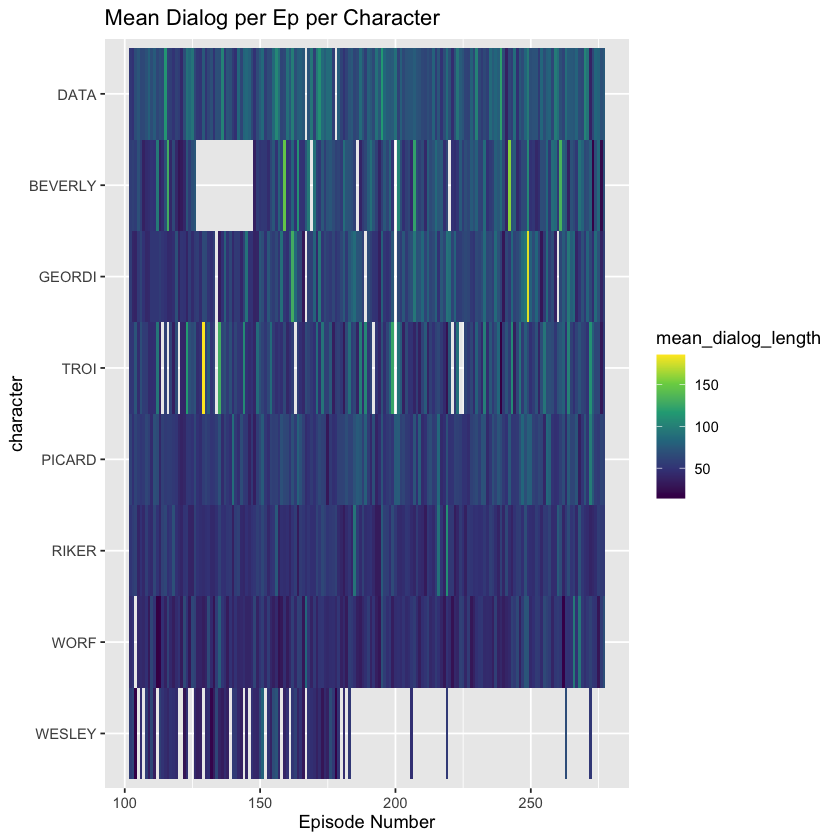

In [85]:

ord <- dialog_len_per_ep%>%
    group_by(character)%>%
    summarize(ovmean = mean(mean_dialog_length))%>%
    arrange(ovmean)%>%
    pull(character)

dialog_len_per_ep <- dialog_len_per_ep%>%
    mutate(character = factor(character, levels = ord))

df_heat <- dialog_len_per_ep %>%
    ggplot(aes(x = episode_number, y = character, fill = mean_dialog_length)) +
    geom_tile()+
    scale_fill_viridis_c() +
    labs(title = "Mean Dialog per Ep per Character",
        x = "Episode Number",
        y = "character"
    )

df_heat
head(dialog_len_per_ep)
ord